# Préparation de l'environement

In [1]:
import os
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

drive_dir = "/content/drive/MyDrive/BDLE/"
os.makedirs(drive_dir, exist_ok=True)
os.listdir(drive_dir)

Mounted at /content/drive


['housing.csv']

In [2]:
!pip install -q pyspark
!pip install -q findspark

     |████████████████████████████████| 281.3 MB 42 kB/s 
     |████████████████████████████████| 198 kB 46.5 MB/s 


In [3]:
import os
# !find /usr/local -name "pyspark"
os.environ["SPARK_HOME"] = "/usr/local/lib/python3.7/dist-packages/pyspark"
os.environ["JAVA_HOME"] = "/usr"

In [4]:
# Principaux import
import findspark
from pyspark.sql import SparkSession 
from pyspark import SparkConf  

# pour les dataframe et udf
from pyspark.sql import *  
from pyspark.sql.functions import *
from pyspark.sql.types import *
from datetime import *

# pour le chronomètre
import time

# initialise les variables d'environnement pour spark
findspark.init()

# Démarrage session spark 
# --------------------------
def demarrer_spark():
  local = "local[*]"
  appName = "TP"
  configLocale = SparkConf().setAppName(appName).setMaster(local).\
  set("spark.executor.memory", "6G").\
  set("spark.driver.memory","6G").\
  set("spark.sql.catalogImplementation","in-memory")
  
  spark = SparkSession.builder.config(conf = configLocale).getOrCreate()
  sc = spark.sparkContext
  sc.setLogLevel("ERROR")
  
  spark.conf.set("spark.sql.autoBroadcastJoinThreshold","-1")

  # On ajuste l'environnement d'exécution des requêtes à la taille du cluster (4 coeurs)
  spark.conf.set("spark.sql.shuffle.partitions","4")    
  print("session démarrée, son id est ", sc.applicationId)
  return spark
spark = demarrer_spark()

session démarrée, son id est  local-1637528284936


In [5]:
# on utilise 8 partitions au lieu de 200 par défaut
spark.conf.set("spark.sql.shuffle.partitions", "8")
print("Nombre de partitions utilisées : ", spark.conf.get("spark.sql.shuffle.partitions"))

Nombre de partitions utilisées :  8


# Préparation des données

## Chargement des données

In [6]:
houses =  spark.read\
            .format("csv").option("header", "true")\
            .option("inferSchema", "true")\
            .load(drive_dir +"housing.csv")
houses.printSchema()

root
 |-- id: string (nullable = true)
 |-- url: string (nullable = true)
 |-- region: string (nullable = true)
 |-- region_url: string (nullable = true)
 |-- price: string (nullable = true)
 |-- type: string (nullable = true)
 |-- sqfeet: string (nullable = true)
 |-- beds: string (nullable = true)
 |-- baths: string (nullable = true)
 |-- cats_allowed: string (nullable = true)
 |-- dogs_allowed: string (nullable = true)
 |-- smoking_allowed: string (nullable = true)
 |-- wheelchair_access: string (nullable = true)
 |-- electric_vehicle_charge: integer (nullable = true)
 |-- comes_furnished: string (nullable = true)
 |-- laundry_options: string (nullable = true)
 |-- parking_options: string (nullable = true)
 |-- image_url: string (nullable = true)
 |-- description: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- state: string (nullable = true)



In [ ]:
houses.show()

+----------+--------------------+------------+--------------------+-----+---------+------+----+-----+------------+------------+---------------+-----------------+-----------------------+---------------+---------------+------------------+--------------------+--------------------+-------+--------+-----+
|        id|                 url|      region|          region_url|price|     type|sqfeet|beds|baths|cats_allowed|dogs_allowed|smoking_allowed|wheelchair_access|electric_vehicle_charge|comes_furnished|laundry_options|   parking_options|           image_url|         description|    lat|    long|state|
+----------+--------------------+------------+--------------------+-----+---------+------+----+-----+------------+------------+---------------+-----------------+-----------------------+---------------+---------------+------------------+--------------------+--------------------+-------+--------+-----+
|7049044568|https://reno.crai...|reno / tahoe|https://reno.crai...| 1148|apartment|  1078|   3

## Nettoyage des données

### Colonne "State"
On sait qu'il y a 50 states aux usa, mais cependant:

In [ ]:
print("Nombre de states dans le dataset:\n")
houses.groupBy('state').agg(count('*').alias('count')).orderBy(desc('count')).count()

Nombre de states dans le dataset:



4442

Lorsque on trie les states par nombre de maisons, on remarques que les 50 premiers sont les vrais, alors que le reste est dû à des erreurs lors de la collection des données:

In [ ]:
print("Nombre maisons par state:\n")
houses.groupBy('state').agg(count('*').alias('count')).orderBy(desc('count')).show(60)

Nombre maisons par state:

+--------------------+-----+
|               state|count|
+--------------------+-----+
|                  ca|31984|
|                  fl|31025|
|                  tx|30151|
|                  nc|17601|
|                  mi|13866|
|                  ga|13334|
|                  oh|12567|
|                  tn|11172|
|                  co|10951|
|                  va|10573|
|                  ny| 9739|
|                  sc| 9666|
|                  il| 9277|
|                  pa| 9252|
|                  al| 7799|
|                  ks| 7770|
|                  or| 7718|
|                  mn| 7339|
|                  ia| 7327|
|                  la| 6966|
|                  md| 6897|
|                  wa| 6731|
|                  wi| 6346|
|                  az| 6340|
|                  in| 6253|
|                  ok| 5582|
|                  nj| 5536|
|                  ut| 5101|
|                  ky| 4955|
|                  ms| 4871|
|               

On va remplacer toutes les valeurs qui ne sont pas de vrai states par des nulls:

In [7]:
states_count = houses.groupBy('state').agg(count('*').alias('states_count')).withColumnRenamed('state', '_state')
houses_states_count = houses.join(states_count, houses.state == states_count._state)
windowSpec  = Window.orderBy(desc("states_count"))
houses_states_count = houses_states_count.withColumn("dense_rank_states_count",dense_rank().over(windowSpec))
houses_cleaned_1 = houses_states_count.withColumn('state', \
                when(houses_states_count.dense_rank_states_count > 50, regexp_replace(houses_states_count.state,'*',None)).otherwise(houses_states_count.state))\
                .drop('_state').drop('states_count').drop('dense_rank_states_count')
houses_cleaned_1.show(10)

+----------+--------------------+------------+--------------------+-----+---------+------+----+-----+------------+------------+---------------+-----------------+-----------------------+---------------+---------------+------------------+--------------------+--------------------+-------+--------+-----+
|        id|                 url|      region|          region_url|price|     type|sqfeet|beds|baths|cats_allowed|dogs_allowed|smoking_allowed|wheelchair_access|electric_vehicle_charge|comes_furnished|laundry_options|   parking_options|           image_url|         description|    lat|    long|state|
+----------+--------------------+------------+--------------------+-----+---------+------+----+-----+------------+------------+---------------+-----------------+-----------------------+---------------+---------------+------------------+--------------------+--------------------+-------+--------+-----+
|7049044568|https://reno.crai...|reno / tahoe|https://reno.crai...| 1148|apartment|  1078|   3

In [ ]:
print("Nombre de states dans le dataset:\n")
houses_cleaned_1.groupBy('state').agg(count('*').alias('count')).orderBy(desc('count')).count()

Nombre de states dans le dataset:



51

Le 1 en plus c'est pour les maisons avec une valeur de state "null"

### Colonnes avec valeurs numériques

*   On va caster les colonnes avec des valeurs numériques vers le type float
*   On ne va pas caster "long" et "lat" parceque on va les enlever dans ce qui suit, vu qu'on va pas les utiliser pour notre prédiction.




In [8]:
numerical_features = ['beds','baths','comes_furnished', 'price',
                      'sqfeet','cats_allowed','dogs_allowed','smoking_allowed',
                      'wheelchair_access','electric_vehicle_charge']
houses_cleaned_2 = houses_cleaned_1
for col_name in numerical_features:
    houses_cleaned_2 = houses_cleaned_2.withColumn(col_name, col(col_name).cast('float'))
houses_cleaned_2.show(10)

+----------+--------------------+------------+--------------------+------+---------+------+----+-----+------------+------------+---------------+-----------------+-----------------------+---------------+---------------+------------------+--------------------+--------------------+-------+--------+-----+
|        id|                 url|      region|          region_url| price|     type|sqfeet|beds|baths|cats_allowed|dogs_allowed|smoking_allowed|wheelchair_access|electric_vehicle_charge|comes_furnished|laundry_options|   parking_options|           image_url|         description|    lat|    long|state|
+----------+--------------------+------------+--------------------+------+---------+------+----+-----+------------+------------+---------------+-----------------+-----------------------+---------------+---------------+------------------+--------------------+--------------------+-------+--------+-----+
|7049044568|https://reno.crai...|reno / tahoe|https://reno.crai...|1148.0|apartment|1078.0|

### Colonne "Price"

On commence par éliminer les maisons avec un prix de loyer mensuel de moins de 10$, ils sont trop présents dans la datasets et on est sur que c'est dû à cause des erreurs lors de la collection des données ou bien que c'est des fausses annonces. 

In [9]:
houses_cleaned_3 = houses_cleaned_2.select('*').where('price > 10')

En explorant les valeurs de la colonne "Price", on remarque qu'elle est pleine de outliers qu'on doit nétoyer. On donne quelques exemples

In [ ]:
print("Nombre total de maisons avec un prix de loyer mensuel moins de 100$: ", houses_cleaned_3.where('price < 100').count())
print("Nombre total de maisons avec un prix de loyer mensuel plus de 100,000$: ", houses_cleaned_3.where ('price > 100000').count())

Nombre total de maisons avec un prix de loyer mensuel moins de 100$:  142
Nombre total de maisons avec un prix de loyer mensuel plus de 100,000$:  94


On remarque que parfois le prix est multiplié par 1000 ou même 10,000 parfois par erreur, comme dans l'annonce suivante. La description dit que le prix "Starting  at: \$854.00\-\$874.00" alors que l'attribut prix a 859864.0$ comme prix

In [ ]:
houses_cleaned_3.orderBy(desc('price')).collect()[15]['description'], houses_cleaned_3.orderBy(desc('price')).collect()[15]['price']

('A/62 Apartments \t 2Bedroom (2x1) (802sqft) Starting at: $854.00-$874.00 Application Fee: $35.00 Security Deposit: $400.00  â\x80¢\tBrush Nickel Accent* â\x80¢\tExpansive Walk-In Closet in all apartments! â\x80¢\tSplit Floor Plan â\x80¢\tUpgraded White Kitchen Cabinets* â\x80¢\tBedroom Window Seats* â\x80¢\tMicrowave included in appliance package â\x80¢\t6-panel doors â\x80¢\tUSB port inside unit â\x80¢\tUpdated ceiling fan â\x80¢\tUpdated bathroom hardware â\x80¢\tNew Black Appliances   Our two bedroom/one bathroom apartment home has a master suite that offers space, space and more space along with a huge walk-in closet that will knock your socks off. There is a great gourmet style eat-in kitchen with all appliances included.  Your new kitchen will also provide a generous amount of cabinet space for your family needs.  http://www.a62apts.com Phone:  show contact info    A/62 Apartments 6111 Allisonville Rd. Indianapolis, IN 46220  Office Hours Mon-Fri.-9:00am-6:00pm Sat. 10:00am-5:0

Et dans celle-ci, où le prix est multiplié par 10,000 (Dans la description c'est \$755.00 - \$800.00):

In [ ]:
tmp = houses_cleaned_3.orderBy(desc('price')).collect()

In [ ]:
tmp[10]['description'], tmp[10]['price']

("Palatka Oaks Apartments\t                        Property Address\t                        \t                          200 College Road                              Palatka, FL, 32177\t                        \t\t\t\t\t\thttp://palatkaoaks.prospectportal.com/su/f7gvpz\t\t\t\t\t    Palatka Oaks Apartments gives you everything you need to live easy.  We offer single story living, private patios, ample parking, individual private entrances, on-site manager, maintenance free living and so much more! You'll enjoy a premier location convenient to shopping, banking, and St. John's River State College. With a variety of floor plans to choose from, we're certain there is one that's just right for you. This one bedroom unit offers new floors, cabinets appliances and fixtures! Available NOW!  Apply online or call  show contact info  now for more details.Now introducing our Preferred Employer Program! Employees of Putnam County School District, Georgia Pacific, Seminole Electric, and St. Johns R

On va éliminer les maisons avec un prix de loyer mensuel supérieur à 100,000$:

In [10]:
houses_cleaned_4 = houses_cleaned_3
houses_cleaned_4 = houses_cleaned_4.select('*').where('price < 100000')

In [ ]:
houses_cleaned_4.orderBy(desc('price')).show()

+----------+--------------------+------------+--------------------+-------+------------+------+----+-----+------------+------------+---------------+-----------------+-----------------------+---------------+---------------+------------------+--------------------+--------------------+-------+--------+-----+
|        id|                 url|      region|          region_url|  price|        type|sqfeet|beds|baths|cats_allowed|dogs_allowed|smoking_allowed|wheelchair_access|electric_vehicle_charge|comes_furnished|laundry_options|   parking_options|           image_url|         description|    lat|    long|state|
+----------+--------------------+------------+--------------------+-------+------------+------+----+-----+------------+------------+---------------+-----------------+-----------------------+---------------+---------------+------------------+--------------------+--------------------+-------+--------+-----+
|7039036774|https://sacrament...|  sacramento|https://sacrament...|95834.0|   a

On remarque aussi que le prix qu'on a n'est pas toujours le loyer mensuel de la maison, mais il s'agit parfois du prix par nuit ou bien par semain comme montre l'exemple suivant

In [ ]:
houses_cleaned_4.orderBy(asc('price')).collect()[90]['description'], houses_cleaned_4.orderBy(asc('price')).collect()[90]['price']

('***CALL & ASK ABOUT OUR FURNISHED UNITS. STARTING AT JUST $55 A NIGHT, COME & TOUR YOUR NEW HOME AWAY FROM HOME!!!***  Welcome to Ross Estates, where you will experience, value and commitment to customer service satisfaction as it was meant to be! Our pattern of ownership, development and management enables us to provide you with consistent, reliable and dedicated service. Ross Estates is conveniently located at Lee Boulevard and 67th Street, just minutes from Fort Sill, home to the Field Artillery School, Cameron University, Great Plains Technology Center, Comanche County Memorial Hospital, and historic downtown Lawton. Lawton is considered Comanche County center for major shopping, dining, and recreational activities. Call or stop in today or your tour!    -Unique Features â\x80¢ Grilling Area Close To Pool   -Pet Friendly  Dogs and Cats Allowed: $350 pet registration fee. $30 monthly pet rent. 80-pound weight limit at full growth. (Breed restrictions apply, call for details.) â\x8

Pour les maisons avec une valeur de l'attribut prix inférieur à 300 et leur description contient l'une des propositions: "nightly", "per night", "/night", "a night" on va multiplier leurs prix par 30.

In [11]:
houses_cleaned_5 = houses_cleaned_4
houses_cleaned_5 = houses_cleaned_5.withColumn('price', \
                when((lower(col('description')).contains('nightly') | lower(col('description')).contains('a night') \
               | lower(col('description')).contains('per night') | lower(col('description')).contains('/night')) & (houses_cleaned_5.price < 300), houses_cleaned_5.price * 30)\
               .otherwise(houses_cleaned_5.price))

On a réussi à corriger la valeur de l'attribut prix pour un certain nombre de maisons qui avaient le prix par nuit au lieu du prix mensuel

In [ ]:
print("Nombre total de maisons avec un prix de loyer mensuel moins de 100$: ", houses_cleaned_5.where('price < 100').count())

Nombre total de maisons avec un prix de loyer mensuel moins de 100$:  116


Pour les maisons avec une valeur de l'attribut prix inférieur à 1000 et leur description contient l'une des propositions: "weekly", "per week", "/week", "a week" on va multiplier leurs prix par 4.

In [12]:
houses_cleaned_6 = houses_cleaned_5
houses_cleaned_6 = houses_cleaned_6.withColumn('price', \
                when((lower(col('description')).contains('weekly') | lower(col('description')).contains('a week') \
               | lower(col('description')).contains('per week') | lower(col('description')).contains('/week')) & (houses_cleaned_6.price < 1000), houses_cleaned_6.price * 4)\
               .otherwise(houses_cleaned_6.price))

Pour terminer avec les outliers, on utilise la méthode du z-score pour les nétoyer, on choisit 2 comme threshold:
On calcule d'abord la moyenne et l'écart type avant de pouvoir calculer le z-score  

In [13]:
stats_avg = houses_cleaned_6.select('price').agg(avg('price').alias('mean'))
stats_std = houses_cleaned_6.select('price').agg(stddev('price').alias('std'))
stats = houses_cleaned_6.select('*').join(stats_avg).join(stats_std)
stats = stats.select('*', ((stats.price - stats.mean) / stats.std).alias('zscore'))

In [ ]:
stats.orderBy(desc('zscore')).show()

+----------+--------------------+------------+--------------------+-------+------------+------+----+-----+------------+------------+---------------+-----------------+-----------------------+---------------+---------------+------------------+--------------------+--------------------+-------+--------+-----+------------------+------------------+-----------------+
|        id|                 url|      region|          region_url|  price|        type|sqfeet|beds|baths|cats_allowed|dogs_allowed|smoking_allowed|wheelchair_access|electric_vehicle_charge|comes_furnished|laundry_options|   parking_options|           image_url|         description|    lat|    long|state|              mean|               std|           zscore|
+----------+--------------------+------------+--------------------+-------+------------+------+----+-----+------------+------------+---------------+-----------------+-----------------------+---------------+---------------+------------------+--------------------+------------

In [14]:
houses_cleaned_7 = stats.select('*').where('zscore < 2 and zscore > -2')

Comme dernière étape, on va éliminer les maisons avec un prix de loyer inferieur à 100$, vu que ce sont des prix très petits pour un loyer mensuel, et au même temps leurs description ne précisent pas si par nuit ou par semaine ou autre chose.

In [15]:
houses_cleaned_8 = houses_cleaned_7.select('*').where('price > 100')

In [ ]:
houses_cleaned_8.count()

378003

### Colonne "Beds", "Baths" and "sqfeet"
On va utiliser la méthode du z-score encore une fois pour éliminer les outliers par rapports à ces attributs. 

In [16]:
houses_cleaned_9 = houses_cleaned_8.drop('mean').drop('std').drop('zscore')
stats_avg = houses_cleaned_9.select('beds').agg(avg('beds').alias('mean'))
stats_std = houses_cleaned_9.select('beds').agg(stddev('beds').alias('std'))
stats = houses_cleaned_9.select('*').join(stats_avg).join(stats_std)
stats = stats.select('*', ((stats.beds - stats.mean) / stats.std).alias('zscore'))

On peut clairement voir que les maisons avec des z-scores élevés ont un nombre illogique de lits "beds" (1100, 1000 ...). Ils doivent être enlevés.

In [17]:
stats.orderBy(desc('zscore')).show()

+----------+--------------------+--------------------+--------------------+------+---------+------+------+-----+------------+------------+---------------+-----------------+-----------------------+---------------+---------------+------------------+--------------------+--------------------+-----------+--------+-----+-----------------+-----------------+------------------+
|        id|                 url|              region|          region_url| price|     type|sqfeet|  beds|baths|cats_allowed|dogs_allowed|smoking_allowed|wheelchair_access|electric_vehicle_charge|comes_furnished|laundry_options|   parking_options|           image_url|         description|        lat|    long|state|             mean|              std|            zscore|
+----------+--------------------+--------------------+--------------------+------+---------+------+------+-----+------------+------------+---------------+-----------------+-----------------------+---------------+---------------+------------------+---------

In [18]:
houses_cleaned_9 = stats.select('*').where('zscore < 2 and zscore > -2').drop('mean').drop('std').drop('zscore')

In [19]:
houses_cleaned_91 = houses_cleaned_9.drop('mean').drop('std').drop('zscore')
stats_avg = houses_cleaned_91.select('baths').agg(avg('baths').alias('mean'))
stats_std = houses_cleaned_91.select('baths').agg(stddev('baths').alias('std'))
stats = houses_cleaned_91.select('*').join(stats_avg).join(stats_std)
stats = stats.select('*', ((stats.baths - stats.mean) / stats.std).alias('zscore'))

In [21]:
houses_cleaned_91 = stats.select('*').where('zscore < 2 and zscore > -2').drop('mean').drop('std').drop('zscore')

In [22]:
houses_cleaned_92 = houses_cleaned_91.drop('mean').drop('std').drop('zscore')
stats_avg = houses_cleaned_92.select('sqfeet').agg(avg('sqfeet').alias('mean'))
stats_std = houses_cleaned_92.select('sqfeet').agg(stddev('sqfeet').alias('std'))
stats = houses_cleaned_92.select('*').join(stats_avg).join(stats_std)
stats = stats.select('*', ((stats.sqfeet - stats.mean) / stats.std).alias('zscore'))

Même remarque qu'avant avec la surface

In [23]:
stats.orderBy(desc('zscore')).show()

+----------+--------------------+--------------------+--------------------+------+---------+---------+----+-----+------------+------------+---------------+-----------------+-----------------------+---------------+------------------+------------------+--------------------+--------------------+-------+--------+-----+------------------+-----------------+------------------+
|        id|                 url|              region|          region_url| price|     type|   sqfeet|beds|baths|cats_allowed|dogs_allowed|smoking_allowed|wheelchair_access|electric_vehicle_charge|comes_furnished|   laundry_options|   parking_options|           image_url|         description|    lat|    long|state|              mean|              std|            zscore|
+----------+--------------------+--------------------+--------------------+------+---------+---------+----+-----+------------+------------+---------------+-----------------+-----------------------+---------------+------------------+------------------+---

In [24]:
houses_cleaned_92 = stats.select('*').where('zscore < 2 and zscore > -2').drop('mean').drop('std').drop('zscore')

In [ ]:
houses_cleaned_92.count()

367379

### Imputation des valeurs nuls

In [ ]:
houses_cleaned_92.where('state is NULL').count()

13368

In [ ]:
houses_cleaned_92.where('region is NULL').count()

0

In [ ]:
houses_cleaned_92.where('type is NULL').count()

0

In [ ]:
houses_cleaned_92.where('sqfeet is NULL').count()

0

In [ ]:
houses_cleaned_92.where('beds is NULL').count()

0

In [ ]:
houses_cleaned_92.where('baths is NULL').count()

0

In [ ]:
houses_cleaned_92.where('cats_allowed is NULL').count()

0

In [ ]:
houses_cleaned_92.where('dogs_allowed is NULL').count()

0

In [ ]:
houses_cleaned_92.where('smoking_allowed is NULL').count()

0

In [ ]:
houses_cleaned_92.where('wheelchair_access is NULL').count()

0

In [ ]:
houses_cleaned_92.where('electric_vehicle_charge is NULL').count()

0

In [ ]:
houses_cleaned_92.where('comes_furnished is NULL').count()

0

In [ ]:
houses_cleaned_92.where('laundry_options is NULL').count()

77939

In [ ]:
houses_cleaned_92.where('parking_options is NULL').count()

138618

Le nombre de valeurs null pour l'attribut parking_option est très élevé. Cet attribut dépend beaucoup plus sur le l'attribut type, qui représente le type de la maison. On va remplacer les valeurs null avec la valeur parking_option la plus fréquente pour le type de cette maison

In [25]:
windowSpec  = Window.orderBy(desc("count")).partitionBy('type')
tmp = houses_cleaned_92.where('parking_options is not null').select('type', 'parking_options').groupBy('type', 'parking_options').agg(count('*').alias('count'))\
    .withColumn("dense_rank_parking_options_count",dense_rank().over(windowSpec)).where('dense_rank_parking_options_count = 1')

In [26]:
tmp.show(100)

+---------------+------------------+------+--------------------------------+
|           type|   parking_options| count|dense_rank_parking_options_count|
+---------------+------------------+------+--------------------------------+
|      apartment|off-street parking|105608|                               1|
|assisted living|off-street parking|     2|                               1|
|          condo|off-street parking|  1800|                               1|
|  cottage/cabin|off-street parking|   420|                               1|
|         duplex|off-street parking|  1827|                               1|
|           flat|off-street parking|   208|                               1|
|          house|   attached garage| 10420|                               1|
|         in-law|off-street parking|    90|                               1|
|           land|off-street parking|     6|                               1|
|           loft|off-street parking|   373|                               1|

On remarque que off-street parking est l'option la plus fréquente pour toute les types des maisons sauf pour house où on a attached garage 

In [28]:
houses_cleaned_9 = houses_cleaned_92.withColumn('parking_options', \
                when((houses_cleaned_92.parking_options.isNull()) & (houses_cleaned_92.type == "house"), "attached garage").otherwise(houses_cleaned_92.parking_options))

houses_cleaned_10 = houses_cleaned_9.withColumn('parking_options', \
                when((houses_cleaned_9.parking_options.isNull()) & (houses_cleaned_9.type != "house"), "off-street parking").otherwise(houses_cleaned_9.parking_options))

In [ ]:
houses_cleaned_10.where('parking_options is NULL').count()

0

On fait la même chose avec laundry_options (on ignore assisted living vu qu'il y a seulement deux maisons de ce type)

In [29]:
windowSpec  = Window.orderBy(desc("count")).partitionBy('type')
tmp = houses_cleaned_10.where('laundry_options is not null').select('type', 'laundry_options').groupBy('type', 'laundry_options').agg(count('*').alias('count'))\
    .withColumn("dense_rank_laundry_options_count",dense_rank().over(windowSpec)).where('dense_rank_laundry_options_count = 1')

In [30]:
tmp.show(100)

+---------------+---------------+------+--------------------------------+
|           type|laundry_options| count|dense_rank_laundry_options_count|
+---------------+---------------+------+--------------------------------+
|      apartment|    w/d in unit|102913|                               1|
|assisted living|    w/d in unit|     1|                               1|
|assisted living|laundry on site|     1|                               1|
|          condo|    w/d in unit|  3127|                               1|
|  cottage/cabin|    w/d in unit|   221|                               1|
|         duplex|    w/d hookups|  2138|                               1|
|           flat|    w/d in unit|   217|                               1|
|          house|    w/d hookups| 10381|                               1|
|         in-law|    w/d in unit|    61|                               1|
|           land|    w/d in unit|     3|                               1|
|           loft|    w/d in unit|   39

In [31]:
houses_cleaned_11 = houses_cleaned_10.withColumn('laundry_options', \
                when((houses_cleaned_10.laundry_options.isNull()) & ((houses_cleaned_10.type == "house") | (houses_cleaned_10.type == "duplex") | (houses_cleaned_10.type == "manufactured")), "w/d hookups").otherwise(houses_cleaned_10.laundry_options))

houses_cleaned_12 = houses_cleaned_11.withColumn('laundry_options', \
                when((houses_cleaned_11.laundry_options.isNull()) & (houses_cleaned_11.type != "house") & (houses_cleaned_11.type != "duplex") & (houses_cleaned_11.type != "manufactured"), "w/d in unit").otherwise(houses_cleaned_11.laundry_options))

In [ ]:
houses_cleaned_12.where('laundry_options is NULL').count()

0

Pour l'attribut état, le nombre de ligne avec des valeurs null représente moins de 3% du dataset, on va éliminer directement toutes ces lignes

In [32]:
houses_cleaned_13 = houses_cleaned_12.select('*').where('state is not null')

In [ ]:
houses_cleaned_13.where('state is NULL').count()

0

## Séléction d'attribut

In [33]:
houses_cleaned = houses_cleaned_13[['region', 'type', 'sqfeet', 'beds','baths','cats_allowed',
             'dogs_allowed','smoking_allowed','wheelchair_access','electric_vehicle_charge',
             'comes_furnished','laundry_options','parking_options', 'state', 'price']]

## Quelques statistiques

In [ ]:
print("Nombre total de données:", houses_cleaned.select('*').count())

Nombre total de données: 364119


In [ ]:
print("Statistique générales sur les attributs:")
houses_cleaned.describe().show()

Statistique générales sur les attributs:
+-------+--------------------+---------+-----------------+------------------+------------------+------------------+-------------------+------------------+-------------------+-----------------------+--------------------+---------------+---------------+------+------------------+
|summary|              region|     type|           sqfeet|              beds|             baths|      cats_allowed|       dogs_allowed|   smoking_allowed|  wheelchair_access|electric_vehicle_charge|     comes_furnished|laundry_options|parking_options| state|             price|
+-------+--------------------+---------+-----------------+------------------+------------------+------------------+-------------------+------------------+-------------------+-----------------------+--------------------+---------------+---------------+------+------------------+
|  count|              354011|   354011|           354011|            354011|            354011|            354011|          

In [ ]:
print("Moyenne de prix et de surface par state:\n")
houses_cleaned.select('state', 'price', 'sqfeet').groupBy('state').agg(avg('price').alias('Avg price'), avg('sqfeet').alias('Avg sqfeet')).orderBy(desc('Avg price')).show(50)

Moyenne de prix et de surface par state:

+-----+------------------+------------------+
|state|         Avg price|        Avg sqfeet|
+-----+------------------+------------------+
|   hi|1922.5208070617907| 832.4728877679697|
|   dc| 1807.679697912039| 871.0390937361173|
|   ca| 1740.174820635463| 928.3293474547318|
|   ma|1729.6300731869594| 984.3222444000887|
|   nj|1692.9481149682717|1013.4912280701755|
|   ri|            1576.5|1020.1131664853101|
|   nh|1563.8063844552394| 974.4365024288688|
|   co| 1464.577128675067| 935.4357579228713|
|   wa|1450.6633281972265| 959.6104776579352|
|   vt|1442.3744769874477|1055.1108786610878|
|   me|1404.9381443298969|1088.6417525773195|
|   md|1384.9613417569194| 955.2224729241877|
|   or|1335.5433315334774| 976.3700053995681|
|   ct| 1320.500287356322| 992.0609195402299|
|   de| 1279.663810483871| 913.3618951612904|
|   ny|1275.7787948131197|1029.7568922305763|
|   fl|1227.6812670299728| 1022.841280653951|
|   ut| 1209.345641025641| 980.8209230

In [ ]:
print("Prix de 1 sqfeet par state:\n")
tmp = houses_cleaned.select('state', 'price', 'sqfeet').groupBy('state').agg(avg('price').alias('Avgprice'), avg('sqfeet').alias('Avgsqfeet'))
tmp = tmp.withColumn('$/sqfeet', col('Avgprice')/col('Avgsqfeet')).orderBy(desc('$/sqfeet')).show(50)

Prix de 1 sqfeet par state:

+-----+------------------+------------------+------------------+
|state|          Avgprice|         Avgsqfeet|          $/sqfeet|
+-----+------------------+------------------+------------------+
|   hi|1922.5208070617907| 832.4728877679697|2.3094095138839448|
|   dc| 1807.679697912039| 871.0390937361173|2.0753140828139207|
|   ca| 1740.174820635463| 928.3293474547318|1.8745231155372035|
|   ma|1729.6300731869594| 984.3222444000887|1.7571786912538085|
|   nj|1692.9481149682717|1013.4912280701755|1.6704122029668418|
|   nh|1563.8063844552394| 974.4365024288688|1.6048314903611618|
|   co| 1464.577128675067| 935.4357579228713|1.5656629717973904|
|   ri|            1576.5|1020.1131664853101| 1.545416775112962|
|   wa|1450.6633281972265| 959.6104776579352|1.5117210180299145|
|   md|1384.9613417569194| 955.2224729241877|1.4498835412835167|
|   de| 1279.663810483871| 913.3618951612904| 1.401047949627782|
|   or|1335.5433315334774| 976.3700053995681|1.36786599767259

In [ ]:
print("Moyenne de prix par type de maison:\n")
houses_cleaned.select('type', 'price').groupBy('type').agg(avg('price').alias('Avg price')).orderBy(desc('Avg price')).show()

Moyenne de prix par type de maison:

+---------------+------------------+
|           type|         Avg price|
+---------------+------------------+
|          condo|1477.8672707889125|
|           flat|          1380.445|
|           loft|1336.5754716981132|
|         in-law| 1309.909090909091|
|          house|1269.2048676289728|
|      townhouse|1261.2875937376662|
|  cottage/cabin|           1229.75|
|         duplex|1208.2517263025738|
|      apartment| 1149.448234187819|
|           land| 992.8571428571429|
|   manufactured| 925.7414255091104|
|assisted living|             700.0|
+---------------+------------------+



In [ ]:
#ds = houses_cleaned.select('*').limit(100)

# Encodage et normalisation des données

In [34]:
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import StandardScaler
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

In [35]:
categorical_features = ['type','region','state','parking_options','laundry_options']
prefix = 'indexed_'
categorical_features_idx = list(map(lambda c:prefix+c, categorical_features))
features_string_indexer = StringIndexer(inputCols=categorical_features, outputCols=categorical_features_idx, handleInvalid='keep')

In [36]:
ohe = OneHotEncoder()
ohe.setInputCols(categorical_features_idx)
prefix = 'oh_'
categorical_features_oh = list(map(lambda c:prefix+c, categorical_features))
ohe.setOutputCols(categorical_features_oh)

OneHotEncoder_b47a2de81c50

In [37]:
features_scale=['beds','baths','sqfeet']
assembler = VectorAssembler(inputCols=features_scale,outputCol="featuresToScale")
scaler = StandardScaler(inputCol="featuresToScale" , outputCol="features_scaled",
                        withStd=True, withMean=False)

In [38]:
stages = [features_string_indexer, ohe, assembler, scaler]
pipeline = Pipeline(stages = stages)
data = pipeline.fit(houses_cleaned).transform(houses_cleaned)
#data.show()

# Split train/test

In [39]:
train_data, test_data = data.randomSplit([0.8, 0.2],100)
train_data=train_data.orderBy(rand())
test_data=test_data.orderBy(rand())

In [42]:
features_to_drop=['price', 'featuresToScale'] + categorical_features + categorical_features_idx + features_scale
X_train, y_train = train_data, train_data.select('price')
X_test, y_test = test_data, test_data.select('price')

for i in features_to_drop :
  X_train=X_train.drop(i)
  X_test=X_test.drop(i)

In [43]:
X_train.columns

['cats_allowed',
 'dogs_allowed',
 'smoking_allowed',
 'wheelchair_access',
 'electric_vehicle_charge',
 'comes_furnished',
 'oh_type',
 'oh_region',
 'oh_state',
 'oh_parking_options',
 'oh_laundry_options',
 'features_scaled']

#  Regression

In [44]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt

In [45]:
assembler = VectorAssembler(inputCols=X_train.columns,outputCol="features")
train_data_transformed = assembler.transform(train_data)
test_data_transformed = assembler.transform(test_data)

In [ ]:
train_data_transformed.count()

302570

## Cross-Validaion using RMSE

In [ ]:
dt = DecisionTreeRegressor(featuresCol="features", 
                           labelCol="price",
                           impurity='variance',
                           maxDepth=20, 
                           maxBins=32,
                           minInstancesPerNode=10
                           )

paramGrid = ParamGridBuilder()\
    .addGrid(dt.maxDepth, [5, 15, 30])\
    .addGrid(dt.maxBins, [403, 430, 470])\
    .addGrid(dt.minInstancesPerNode, [5, 10, 20])\
    .build()

In [ ]:
crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse"),
                          numFolds=3)  

In [ ]:
cvModel = crossval.fit(train_data_transformed)

In [ ]:
print("best MaxDepth is :",cvModel.bestModel._java_obj.getMaxDepth())
print("best maxBins is :",cvModel.bestModel._java_obj.getMaxBins())
print("best minInstancesPerNode is :",cvModel.bestModel._java_obj.getMinInstancesPerNode())

best MaxDepth is : 30
best maxBins is : 430
best minInstancesPerNode is : 5


on fait un autre grid search en changeant les intervals

In [ ]:
paramGrid = ParamGridBuilder()\
    .addGrid(dt.maxDepth, [30])\
    .addGrid(dt.maxBins, [401, 410, 415,420,430])\
    .addGrid(dt.minInstancesPerNode, [1,3,5])\
    .build()

In [ ]:
crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse"),
                          numFolds=3)  

In [ ]:
cvModel = crossval.fit(train_data_transformed)

In [ ]:
print("best MaxDepth is :",cvModel.bestModel._java_obj.getMaxDepth())
print("best maxBins is :",cvModel.bestModel._java_obj.getMaxBins())
print("best minInstancesPerNode is :",cvModel.bestModel._java_obj.getMinInstancesPerNode())

best MaxDepth is : 30
best maxBins is : 401
best minInstancesPerNode is : 5


In [ ]:
paramGrid = ParamGridBuilder()\
    .addGrid(dt.maxDepth, [30])\
    .addGrid(dt.maxBins, [350,390,401,404])\
    .addGrid(dt.minInstancesPerNode, [5])\
    .build()

In [ ]:
crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse"),
                          numFolds=3)  

In [ ]:
cvModel = crossval.fit(train_data_transformed)

In [ ]:
print("best MaxDepth is :",cvModel.bestModel._java_obj.getMaxDepth())
print("best maxBins is :",cvModel.bestModel._java_obj.getMaxBins())
print("best minInstancesPerNode is :",cvModel.bestModel._java_obj.getMinInstancesPerNode())

best MaxDepth is : 30
best maxBins is : 401
best minInstancesPerNode is : 5


Les meilleurs parametres trouvé en utilisant grid search pour une fonction de loss RMSE sont les suivant :


*   MaxDepth = 30
*   MaxBins = 401
*   minInsrancesPerNode = 5



## Fitting model with best params using RMSE

aprés avoir trouvé les meilleurs paramatere en utlisant grid search, on va entrainer maintenant l'ensemble de l'entrainement encore une fois avec ces parametres.

In [46]:
dt = DecisionTreeRegressor(featuresCol="features", 
                           labelCol="price",
                           impurity='variance',
                           maxDepth=30, 
                           maxBins=401,
                           minInstancesPerNode=5
                           )
model_rmse = dt.fit(train_data_transformed)

In [47]:
predictions = model_rmse.transform(test_data_transformed)

In [48]:
predictions_train = model_rmse.transform(train_data_transformed)

In [49]:
evaluator = RegressionEvaluator(
    labelCol="price", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 274.43


aprés avoir entrainer le model, on l'a testé sur l'ensemble de test et on a obtenue un score de 274.43

In [50]:
rmse_train = evaluator.evaluate(predictions_train)
print("Root Mean Squared Error (RMSE) on train data = %g" % rmse_train)

Root Mean Squared Error (RMSE) on train data = 247.142


## Evolution du vecteur d’importance des features RMSE

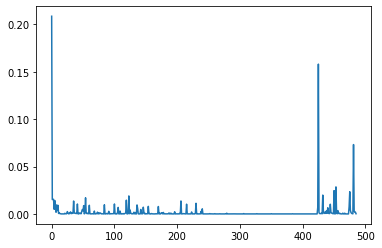

In [ ]:
plt.plot(model_rmse.featureImportances)


## Cross-validation using MAE

In [ ]:
dt = DecisionTreeRegressor(featuresCol="features", 
                           labelCol="price",
                           impurity='variance',
                           maxDepth=20, 
                           maxBins=32,
                           minInstancesPerNode=10
                           )

paramGrid = ParamGridBuilder()\
    .addGrid(dt.maxDepth, [5, 15, 30])\
    .addGrid(dt.maxBins, [403, 430, 470])\
    .addGrid(dt.minInstancesPerNode, [5, 10, 20])\
    .build()

In [ ]:
crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="mae"),
                          numFolds=3)  

In [ ]:
cvModel = crossval.fit(train_data_transformed)

In [ ]:
print("best MaxDepth is :",cvModel.bestModel._java_obj.getMaxDepth())
print("best maxBins is :",cvModel.bestModel._java_obj.getMaxBins())
print("best minInstancesPerNode is :",cvModel.bestModel._java_obj.getMinInstancesPerNode())

best MaxDepth is : 30
best maxBins is : 430
best minInstancesPerNode is : 5


In [ ]:
paramGrid = ParamGridBuilder()\
    .addGrid(dt.maxDepth, [30])\
    .addGrid(dt.maxBins, [401, 410, 415,420,430])\
    .addGrid(dt.minInstancesPerNode, [1,3,5])\
    .build()

In [ ]:
crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="mae"),
                          numFolds=3)  

In [ ]:
cvModel = crossval.fit(train_data_transformed)

In [ ]:
print("best MaxDepth is :",cvModel.bestModel._java_obj.getMaxDepth())
print("best maxBins is :",cvModel.bestModel._java_obj.getMaxBins())
print("best minInstancesPerNode is :",cvModel.bestModel._java_obj.getMinInstancesPerNode())

best MaxDepth is : 30
best maxBins is : 420
best minInstancesPerNode is : 1


In [ ]:
paramGrid = ParamGridBuilder()\
    .addGrid(dt.maxDepth, [30])\
    .addGrid(dt.maxBins, [420,423,426,430])\
    .addGrid(dt.minInstancesPerNode, [1])\
    .build()

In [ ]:
crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="mae"),
                          numFolds=3)  

In [ ]:
cvModel = crossval.fit(train_data_transformed)

In [ ]:
print("best MaxDepth is :",cvModel.bestModel._java_obj.getMaxDepth())
print("best maxBins is :",cvModel.bestModel._java_obj.getMaxBins())
print("best minInstancesPerNode is :",cvModel.bestModel._java_obj.getMinInstancesPerNode())

best MaxDepth is : 30
best maxBins is : 420
best minInstancesPerNode is : 1


Les meilleurs parametres trouvé en utilisant grid search pour une fonction de loss RMSE sont les suivant :


*   MaxDepth = 30
*   MaxBins = 420
*   minInsrancesPerNode = 1


## Fitting model with best params using MAE

aprés avoir trouvé les meilleurs paramatere en utlisant grid search sur l'ensemble de validation, on va entrainer maintenant l'ensemble de l'entrainement encore une fois avec ces parametres.

In [ ]:
dt = DecisionTreeRegressor(featuresCol="features", 
                           labelCol="price",
                           impurity='variance',
                           maxDepth=30, 
                           maxBins=420,
                           minInstancesPerNode=1
                           )
model = dt.fit(train_data_transformed)

In [ ]:
predictions = model.transform(test_data_transformed)

In [ ]:
predictions_train = model.transform(train_data_transformed)

In [ ]:
evaluator = RegressionEvaluator(
    labelCol="price", predictionCol="prediction", metricName="mae")
mae = evaluator.evaluate(predictions)
print("Mean absolute error (MAE) on test data = %g" % mae)

Mean absolute error (MAE) on test data = 162.431


aprés avoir entrainer le model, on l'a testé sur l'ensemble de test et on a obtenue un score de 162.431





## Evolution du vecteur d’importance des features MAE

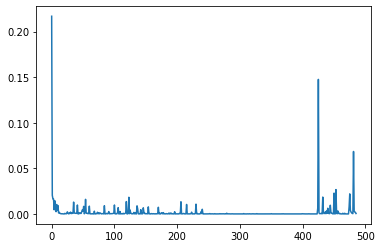

In [ ]:
plt.plot(model.featureImportances)


## Analyse comparative

* dans les deux cas, pour chaque changement des intervals 
d'hyperparametre, on réussi à diminuer le loss, et cela est du à bien choisir les intrervales qui s'approches des paramateres optimaux

* on remarque que les parametres optimals changent en changeant la metric, et cela parait evident, car en changeant l'objectif de notre arbre (dans notre cas la fonction de loss) le comportement de l'arbre change, et donc il lui faut des hyperparametres differents.

* la deuxieme chose qu'on peut remarquer c'est qu'on a obtenu des meilleurs résultats avec la fonction de loss MAE, et donc on peut conclure que c'est la fonction de loss la mieux adapté pour traiter notre tâche de regression.

* concernant les vecteurs d'importance de features, on remarque qu'ils sont quasiment identitiques, et donc en changeant la fonction de loss n'efffecte pas beaucoup l'importance des features.